In [272]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from IPython.display import Image

# 1. Data exploration & cleaning

In this section we will clean the data to output a dataset on which we can learn our models.

In [173]:
# Import data
data = pd.read_csv('CrowdstormingDataJuly1st.csv')

In [174]:
data.ix[:3,:14]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0,1
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0,0


In [175]:
data.ix[:3,14:]

,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [176]:
# We noticed that for some players, there isn't a photo, so their skin tone couldn't be rated.
# So we decided to drop all rows without photoID.
data.dropna(subset=["photoID"],inplace=True)

In [177]:
# Since the data is consisted of dyads of players and referees, we make sure that we have only one entry per dyad
indexed_data=data.set_index(keys=['player','refNum'])
print("The index (player,refNum) is unique: "+str(indexed_data.index.is_unique))

The index (player,refNum) is unique: False


There is not a single player-referee dyad. This is the first problem we need to fix. Let's figure out what is going on:

In [178]:
### A CHANGER ###
duplicated_data = data.groupby(by=['player','refNum']).count()
duplicated_data = duplicated_data.loc[duplicated_data['club']>1]
indexed_data.loc[duplicated_data.index].head(2)

playerShort                 club leagueCountry  \
player        refNum                                                      
 André Santos 88        andre-santos           Arsenal FC       England   
              88      andre-santos_2  Deportivo La Coruña         Spain   

                        birthday  height  weight           position  games  \
player        refNum                                                         
 André Santos 88      08.03.1983   180.0    74.0      Left Fullback      1   
              88      02.03.1989   178.0    72.0  Center Midfielder      1   

                      victories  ties    ...     rater1  rater2  refCountry  \
player        refNum                     ...                                  
 André Santos 88              0     0    ...       0.50    0.50           3   
              88              0     1    ...       0.25    0.25           3   

                      Alpha_3   meanIAT    nIAT     seIAT   meanExp    nExp  \
player        refNum                                                          
 André Santos 88          ESP  0.369894  1785.0  0.000229  0.588297  1897.0   
              88          ESP  0.369894  1785.0  0.000229  0.588297  1897.0   

                         seExp  
player        refNum            
 André Santos 88      0.001002  
              88      0.001002  

[2 rows x 26 columns]

Now we can see that the origin of the problem is that some players that are transfered from a club to another may have multiple entries for the same referee (one entry per club).
So we have two possible solutions:
1. Merge these entries into one single entry so that we have a single entry per player-ref and aggregate the club and leagueCountry features.
2. Add the club to the index to get an entry per (player,refNum,club).

Since we think that the club may be useful to our classification, we decided to explore the 2nd solution.

In [179]:
indexed_data=data.set_index(keys=['player','refNum','club'])
print("The index (player,refNum,club) is unique: "+str(indexed_data.index.is_unique))

The index (player,refNum,club) is unique: True


## Skintone ratings:

By observing the rating value, we can see that this value does not represent a real classification of players into 5 different classes: It is actually a degree of skin darkness that goes from 0 to 1. So we think that a binary classification is more suited than a multi-class classification. We decided to take the mean of all rates given for every player to decide whether he belongs to class 1 or 0. A problem can arise with people having a mean very close to 0.5, and we decided to compute this proportion of people to decide if we can safely remove them from our data.

In [180]:
#For the classification, we need to unify all the ratings for a given player.
ratings = indexed_data.reset_index().groupby(by=["player"]).agg({"rater1":np.mean,"rater2":np.mean})
ratings["skinRating"]=(ratings["rater1"]+ratings["rater2"])/2
def classify(averageRating):
    if averageRating<=0.375:
        return 0
    elif averageRating>=0.625:
        return 1
    else:
        return 0.5
ratings["class"]=ratings.skinRating.apply(classify)
numberOfPlayer=len(ratings.loc[ratings["class"]==0.5])
total=len(ratings)
print("We found that "
      +str(round((len(ratings.loc[ratings["class"]==0.5])/len(ratings))*100,2))+
      "% of the players belongs to the class 0.5")

We found that 7.38% of the players belongs to the class 0.5


We decide to remove these players and go for a binary classification: 0 is light skin and 1 is dark skin.

In [181]:
ratings=ratings.drop(["rater1","rater2","skinRating"],axis=1)
ratings.columns=["rater"]
final_data = indexed_data.join(ratings)
final_data = final_data.drop(["rater1","rater2"],axis=1)
final_data = final_data[final_data.rater!=0.5]
final_data.head()

,,,playerShort,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,...,photoID,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,rater
player,refNum,club,,,,,,,,,,,,,,,,,,,,,
Lucas Wilchez,1,Real Zaragoza,lucas-wilchez,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,...,95212.jpg,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.0
John Utaka,2,Montpellier HSC,john-utaka,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,...,1663.jpg,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,1.0
Aaron Hughes,4,Fulham FC,aaron-hughes,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,...,3868.jpg,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.0
Aleksandar Kolarov,4,Manchester City,aleksandar-kolarov,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,...,47704.jpg,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.0
Alexander Tettey,4,Norwich City,alexander-tettey,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,...,22356.jpg,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.0


# 2. Supervised classification

## 1. Data pre-processing

In this section we will use a random forest classifier that given a soccer player description outputs his skin color. Since we were grouping our data by (player-referee-club) we will have multiple values per player, we decided to allow this even if it seems wrong at a first sight because the ref and club informations: Some refrees are known of being racist and this may help in the classification. Also, some clubs are known to prefer at a point of time a specific playing style of a specific nation, this may effects the skin color of the players in the club (For example, Barcelona prefers spanish player and style, while Chelsea prefers african players and style).

And to tackle the problem that may arise from our choice, we decided to proceed as follow:
1. Split the player list into players for Test and players for Train. Then split the data according to that: All entries of players for Test will belong to X_Test and all entries of players for Train will belong to X_Train. This prevents us from having some players having data in the boths set which will cause a lot of mistakes is the analysis.
2. Once a model is fitted and a prediction is found, we group all the prediction of entries of every player and take the value that is most proposed as a prediction for that player.
3. We created our own computeScore function that computes the score from the prediction for players instead of prediction for entries (player-ref-club).

In [239]:
supervisedData=final_data.reset_index().set_index(["player"]).drop(['playerShort',# Duplicated data
                                          'photoID',    # Noise
                                          'Alpha_3',     # Duplicated
                                          'meanIAT',    # Related to referee country
                                          'nIAT',       # Related to referee country
                                          'seIAT',      # Related to referee country
                                          'meanExp',    # Related to referee country
                                          'nExp',       # Related to referee country
                                          'seExp',      # Related to referee country
                                         ], axis=1)
players = final_data.reset_index().groupby(by=["player"]).agg({"rater":"first"})

In [241]:
# Split the players into training and testing players
players_train, players_test  = train_test_split(players, test_size=0.25)

Now, we need to encode string labels (i.e. club, position..) into integer values so that we can use as input to our classifier that doesn't accept string type. We will use class **sklearn.preprocessing.LabelEncoder**

In [242]:
# All data
X = supervisedData.drop('rater',axis=1)

# Encode string columns
le = LabelEncoder()
X["club"] = le.fit(X.club).transform(X.club)
X["birthday"] = le.fit(X.birthday).transform(X.birthday)
X["leagueCountry"] = le.fit(X.leagueCountry).transform(X.leagueCountry)
# Position column contain some nan values so we need to convert the type to string before encoding
X.position = X.position.apply(lambda x:str(x))
X["position"] = le.fit(X.position).transform(X.position)

# For height and weight column we will replace nan values with the mean height/weight
#X.weight=X.weight.apply(lambda x:round(float(x),1))
meanWeight = round(X.weight.mean(),0)
X.weight = X.weight.fillna(meanWeight)
#X.height=X.height.apply(lambda x:round(float(x),1))
meanHeight = round(X.height.mean(),0)
X.height = X.height.fillna(meanHeight)

X_train = X.reset_index().set_index(["player"])
X_train = X_train.loc[players_train.index]
X_test = X.reset_index().set_index(["player"])
X_test = X_test.loc[players_test.index]

In [243]:
y_train = supervisedData.reset_index().set_index(["player"])
y_train = y_train.loc[players_train.index]["rater"]
y_test = supervisedData.reset_index().set_index(["player"])
y_test = y_test.loc[players_test.index]["rater"]

# Encode the labels y
y_train = le.fit(y_train).transform(y_train)
y_test = le.fit(y_test).transform(y_test)

In [244]:
X_train.head(2)

,refNum,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refCountry
player,,,,,,,,,,,,,,,,
Roberto Lago,88,19,3,1274,178.0,76.0,7,4,1,2,1,1,0,0,0,3
Roberto Lago,94,19,3,1274,178.0,76.0,7,9,4,3,2,0,2,0,0,3


In [245]:
y_train[:5]

array([0, 0, 0, 0, 0])

## 2. Helper functions:

In [247]:
#The helper function that takes the predictions of all entries with a player and outputs the final prediction for him.
def getPrediction(model,X):
    yHat = model.predict(X)
    yHat = pd.DataFrame(index=X.index, data=yHat)
    yHat.columns=["yHat"]
    result = yHat.join(X,how="left")
    result = result.reset_index().groupby(by=["player"]).agg({"yHat":lambda x:x.value_counts().index[0]})
    return result

In [248]:
#Our own computePrecision that uses the predictions of player instead of predictions of entries.
def computePrecision(model,X):
    yHat = getPrediction(model,X)
    y = final_data.reset_index().groupby(by=["player"]).agg({"rater":lambda x:x.value_counts().index[0]})
    comparison = yHat.join(y,how="left")
    comparison["error"]=comparison["yHat"]==comparison["rater"]
    total = len(comparison)
    correct = len(comparison.loc[comparison.error==True])
    return round((correct/total)*100,2)

## 3. Model construction & validation:

First, let's try a random forest classifier with these basic parameters:
- The number of trees in the forst: **n_estimators=20**
- Unrestricted size: **max depth=None**
- The minimum number of samples required to be at a leaf node: **min_samples_leaf=1**
- Each node can be splitted further if it contains at least two samples **min_samples_splits=2**

In [249]:
# Create the classifier
clf = RandomForestClassifier(n_estimators=20)
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [250]:
# Build a forest of trees from the training set
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [251]:
# Score of our model on the training set
print ("The score of our model on the training set is "+str(computePrecision(clf,X_train))+"%")

The score of our model on the training set is 100.0%


In [252]:
# Score of our model on the validation set
print ("The score of our model on the validation data is "+str(computePrecision(clf,X_test))+"%")

The score of our model on the validation data is 80.77%


We clearly have an overvitting, let's study how the different parameters change the occuracy.

## 3. Parameters & Overfitting:

**Note that: For more reliable result, for a fixed set of parameters, we will compute the median of the score over 100 test for these parameters. This avoids extreme results caused by the random samples selection of the random forest algorithm: Althought this will increase complexity, it will produce more reliable results.**

### a. Number of trees (n_estimators):

We will plot the score (on the validation data) as a function of Number of trees. All the other parameters are unchanged:

In [253]:
# Function that given the number of trees return the score of the model on the validation data
def scoreFromNumEstim (n_estimators):
    obs=[]
    for i in range(1,40):
        clf = RandomForestClassifier(n_estimators).fit(X_train, y_train)
        obs.append(computePrecision(clf,X_test))
    return np.median(obs)

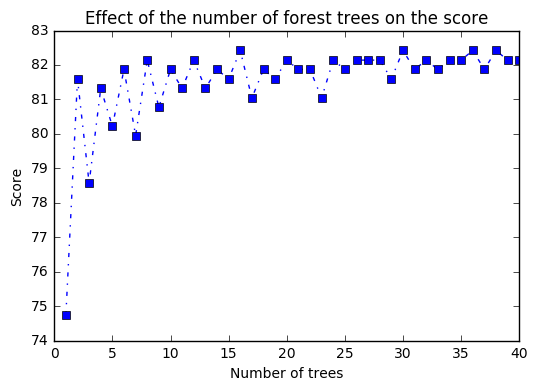

In [254]:
# Plot the score (on the validation data) as a function of Number of trees
treeNum = np.arange(1, 41, 1)
#l1,= plt.plot(treeNum, np.vectorize(scoreFromNumEstim)(n_estimators=treeNum),'bs-.')
plt.xlabel('Number of trees')
plt.ylabel('Score')
plt.title('Effect of the number of forest trees on the score')
plt.show()

**Observation:** We can see from this plot that the score increase linearly with the number of trees until reaching a local maximum (~16 trees). For the number of trees above this local maximum, the score will vary around 81%.

**Conclusion:** The bigger the number of trees is the better performance the model can achieve (especially if the number of trees is relatively small). In fact, the more trees the more **variance** reduction through the ensemble aggregate. However, as seen in this plot, as the number of trees become very large, the performance is not improved that much and there is a tradeoff between complexity and performance.

### b. Max depth:

We will plot the score (on the test set) as a function of the max depth of the tree. All the other parameters are unchanged:

In [255]:
def scoreFromMaxDepth (max_depth):
    obs=[]
    for i in range(1,20):
        clf = RandomForestClassifier(n_estimators=20,max_depth=max_depth).fit(X_train, y_train)
        obs.append(computePrecision(clf,X_test))
    return np.median(obs)

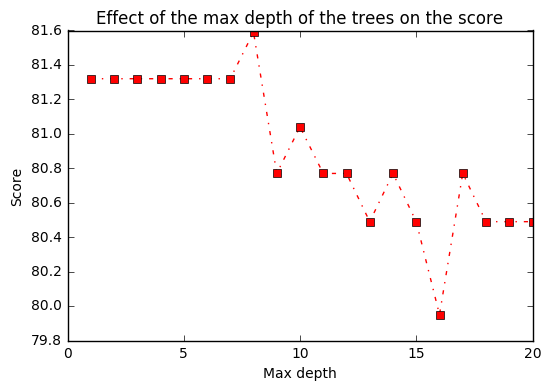

In [207]:
maxDepth = np.arange(1, 21, 1)
#l1,= plt.plot(maxDepth, np.vectorize(scoreFromMaxDepth)(max_depth=maxDepth),'rs-.')
plt.xlabel('Max depth')
plt.ylabel('Score')
plt.title('Effect of the max depth of the trees on the score')
plt.show()

**Observation:** We can see from this plot that the score increases with the maximal depth of the tree until reaching a global maximum (Max depth ~8). Then a slight decrease in performance is observed as max depth increases.

**Conclusion:** The performance increases when we increase the depth of the trees because depth reduce biais especially when the depth is relatively small which cause high biais leading to  poor performance. However, very large depth may cause overfitting: Hence reduce performance.

### c. Minimal number of samples per leaf:**

We will plot the score (on the validation data) as a function of the minimal sample leaf of the tree. All the other parameters are unchanged:

In [256]:
def scoreFromMinSamlpleLeaf (min_samples_leaf):
    obs=[]
    for i in range(1,20):
        clf = RandomForestClassifier(n_estimators=20,min_samples_leaf=min_samples_leaf).fit(X_train, y_train)
        obs.append(computePrecision(clf,X_test))
    return np.median(obs)

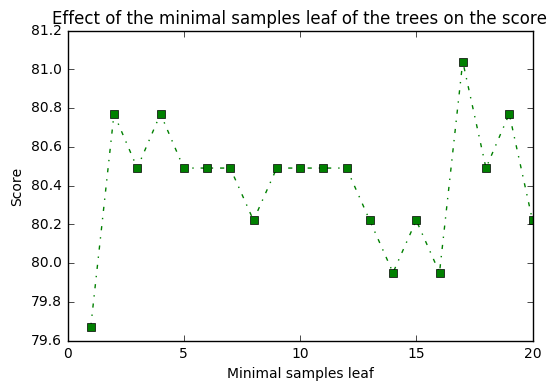

In [211]:
minSamplesLeafs = np.arange(1, 21, 1)
#l1,= plt.plot(minSamplesLeafs, np.vectorize(scoreFromMinSamlpleLeaf)(min_samples_leaf=minSamplesLeafs),'gs-.')
plt.xlabel('Minimal samples leaf')
plt.ylabel('Score')
plt.title('Effect of the minimal samples leaf of the trees on the score')
plt.show()

**Observation:** We can see from this plot that the score is minimal when the minimal number of samples allowed per leaf is very small and when it is very large. In fact optimal scores corresponds to minimal samples leaf values around 17 samples.

**Conclusion:** A small number of samples per leaf means further splitting and hence deeper trees. So as we saw with Max_depth, althought deep trees decrease biais, they cause overfitting which is clear from the increasing part of the curve (increasing min samples/leaf increases performance). On the other hand, further increase of the min number of samples per leaf decreases performance. In fact, large number of samples per leaf means shorter trees and hence increase in the biais which decrease the performance. Hence, not surprising, the optimal value is not too smal nor too large.

### d. Minimal sample split:

We will plot the score (on the validation data) as a function of the minimal sample split of the tree. It means the minimum number of samples above which we can split further. All the other parameters are unchanged:

In [257]:
def scoreFromMinSamlpleSplit (min_samples_split):
    obs=[]
    for i in range(2,20):
        clf = RandomForestClassifier(n_estimators=20,min_samples_split=min_samples_split).fit(X_train, y_train)
        obs.append(computePrecision(clf,X_test))
    return np.median(obs)

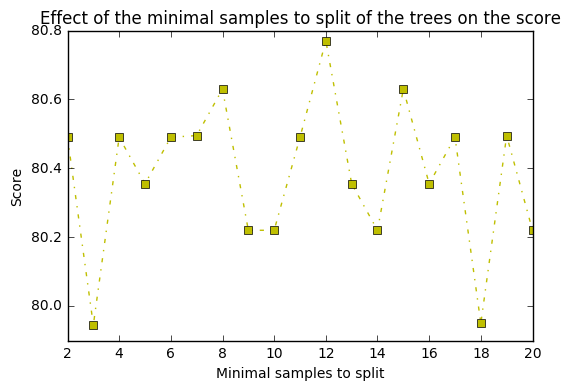

In [215]:
minSamplesSplit = np.arange(2, 21, 1)
#l1,= plt.plot(minSamplesSplit, np.vectorize(scoreFromMinSamlpleSplit)(min_samples_split=minSamplesSplit),'ys-.')
plt.xlabel('Minimal samples to split')
plt.ylabel('Score')
plt.title('Effect of the minimal samples to split of the trees on the score')
plt.show()

**Observation:** Not surprisingly, we can see that the shape of this curve is similar to the minimal sample split curve. In fact, the minimal samples to split is twice to the number of samples per leaf. In other words, splitting when a node has at least 2n samples is equivalent to having a maximal number of samples per leaf of n samples. So the same observation and conclusion of the previous part hold.

### e. Max features:

We will plot the score (on the validation data) as a function of the max number of features to consider when looking for the best split.

In [258]:
def scoreFromMaxFeatures(max_features):
    obs=[]
    for i in range(1,10):
        clf = RandomForestClassifier(n_estimators=20,max_features=max_features).fit(X_train, y_train)
        obs.append(computePrecision(clf,X_test))
    return np.median(obs)

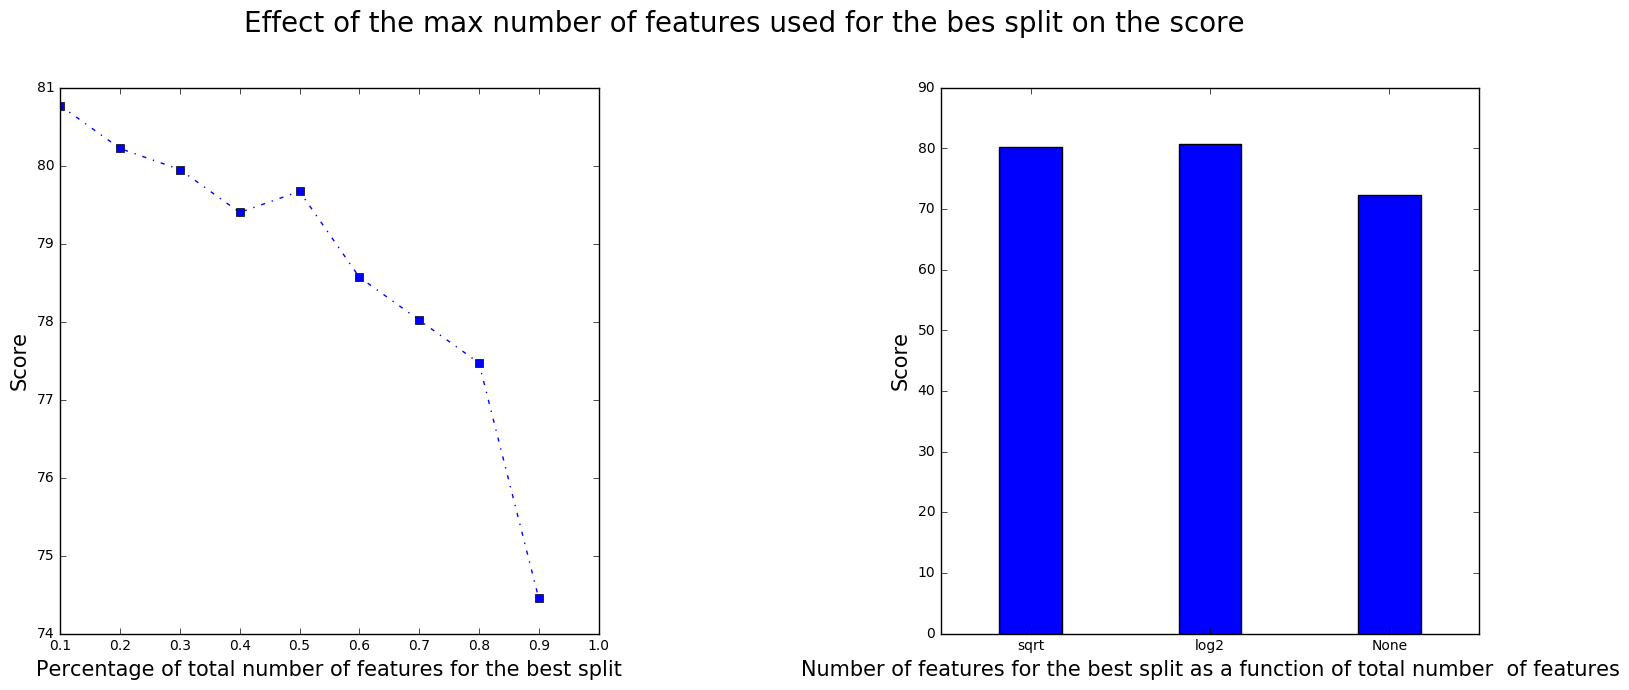

In [219]:
maxFeaturesCont = np.arange(0.1,1,0.1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
maxFeaturesFunc = ['sqrt','log2',None]
#scores=np.vectorize(scoreFromMaxFeatures)(max_features=maxFeaturesFunc)
width = 0.35 
# Plot the score as a function of the number of features
#axes[0].plot(maxFeaturesCont, np.vectorize(scoreFromMaxFeatures)(max_features=maxFeaturesCont),'bs-.')
axes[0].set_xlabel('Percentage of total number of features for the best split',fontsize=15)
axes[0].set_ylabel('Score',fontsize=15)

# Plot a bar chart for scores for pre-built functions
axes[1].bar(range(len(maxFeaturesFunc)), scores, width,align='center')
axes[1].set_xlabel('Number of features for the best split as a function of total number  of features',fontsize=15)
axes[1].set_ylabel('Score',fontsize=15)
plt.sca(axes[1])
plt.xticks(range(len(maxFeaturesFunc )), maxFeaturesFunc, size="medium")

# Translate subplots for better visiualisation
pos = axes[1].get_position()
axes[1].set_position(pos.translated(tx =-0.1,ty=0.1))
fig.suptitle('Effect of the max number of features used for the bes split on the score', fontsize=20)
fig.tight_layout()

**Observation:** Both graphs agree on the fact that the more number of fetures you pick for the best split, the better the performance is. This is shown on the first graph by the increasing aspect of the curve and on the second graph by an optimal score for the 'None' argument (note that None means fetures selected= all features).

**Conclusion:** Normally a big number of features is more likely to causes an overfitting problem because at each split all features will be taken into account. In our case a big number of features does not seem to cause overfitting maybe because of the big difference of importance among features.

### Our final model:

Our final model will have theese paramaters:
- The number of trees in the forst: **n_estimators=20**
- Unrestricted size: **max depth=8**
- The minimum number of samples required to be at a leaf node: **min_samples_leaf=17**
- Each node can be splitted further if it contains at least two samples **min_samples_splits=12**
- Max_features used: **5**

In [260]:
clf = RandomForestClassifier(20,max_depth=8,min_samples_leaf=17,min_samples_split=12,max_features=5).fit(X_train, y_train)

In [238]:
# Score of our model on the training set
print ("The score of our model on the training set is "+str(computePrecision(clf,X_train))+"%")
# Score of our model on the validation set
print ("The score of our model on the validation data is "+str(computePrecision(clf,X_test))+"%")

The score of our model on the training set is 87.27%
The score of our model on the validation data is 80.22%


Now we try to get the most important features with our model.

Feature ranking:
1. feature 2 (0.202125)
2. feature 3 (0.196192)
3. feature 1 (0.165366)
4. feature 5 (0.145302)
5. feature 4 (0.140294)
6. feature 6 (0.109646)
7. feature 15 (0.032281)
8. feature 11 (0.002681)
9. feature 7 (0.001842)
10. feature 10 (0.001780)
11. feature 0 (0.000973)
12. feature 8 (0.000865)
13. feature 12 (0.000324)
14. feature 9 (0.000307)
15. feature 13 (0.000022)
16. feature 14 (0.000000)


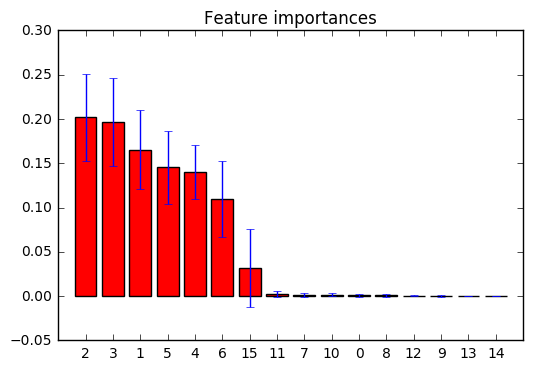

In [224]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

We found that the club and the league are the most important feature, followed by the refNum, the height, the birthday and the weight. The refCountry is also important, and all the other features are unsignficant.

We notice that the birthday is more important than what he shoul be, so we decided to remove it from the bigining, he might be increasing the overfitting of our model.

In [235]:
newX_train = X_train.drop("birthday",axis=1)
newX_test = X_test.drop("birthday",axis=1)
newX = X.drop("birthday",axis=1)
newX.head()

,refNum,club,leagueCountry,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refCountry
player,,,,,,,,,,,,,,,
Lucas Wilchez,1,67,3,177.0,72.0,0,1,0,0,1,0,0,0,0,1
John Utaka,2,48,1,179.0,82.0,11,1,0,0,1,0,1,0,0,2
Aaron Hughes,4,33,0,182.0,71.0,1,1,0,0,1,0,0,0,0,4
Aleksandar Kolarov,4,45,0,187.0,80.0,6,1,1,0,0,0,0,0,0,4
Alexander Tettey,4,51,0,180.0,68.0,4,1,0,0,1,0,0,0,0,4


In [228]:
clf = RandomForestClassifier(20,max_depth=8,min_samples_leaf=17,min_samples_split=12,max_features=5).fit(newX_train, y_train)

In [229]:
# Score of our model on the training set
print ("The score of our model on the training set is "+str(computePrecision(clf,newX_train))+"%")
# Score of our model on the validation set
print ("The score of our model on the validation data is "+str(computePrecision(clf,newX_test))+"%")

The score of our model on the training set is 85.53%
The score of our model on the validation data is 79.95%


Feature ranking:
1. feature 2 (0.231361)
2. feature 1 (0.199386)
3. feature 4 (0.186873)
4. feature 3 (0.173742)
5. feature 5 (0.170604)
6. feature 14 (0.025705)
7. feature 10 (0.004156)
8. feature 6 (0.002638)
9. feature 9 (0.002030)
10. feature 0 (0.001207)
11. feature 7 (0.000965)
12. feature 11 (0.000956)
13. feature 8 (0.000378)
14. feature 13 (0.000000)
15. feature 12 (0.000000)


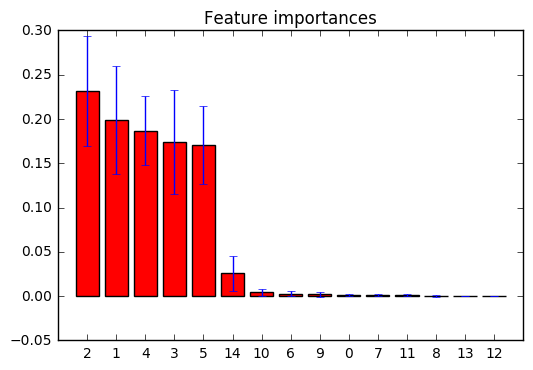

In [232]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(newX.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(newX.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(newX.shape[1]), indices)
plt.xlim([-1, newX.shape[1]])
plt.show()

We found out that the most important features after removing the birthday doesn't change a lot: club, refree, height, leagueCountry and weight. Then the refCountry is less important than the first 5 but more important than the others.

# 2. Unsupervised Learning

## 1. Data pre-processing

In [262]:
unsupervisedData = supervisedData.copy()

# Encode string columns
le = LabelEncoder()
# Position column contain some nan values so we need to convert the type to string before encoding
unsupervisedData.position = unsupervisedData.position.apply(lambda x:str(x))
unsupervisedData["position"] = le.fit(unsupervisedData.position).transform(unsupervisedData.position)

# For height and weight column we will replace nan values with the mean height/weight
meanWeight = round(unsupervisedData.weight.mean(),0)
unsupervisedData.weight = unsupervisedData.weight.fillna(meanWeight)
meanHeight = round(unsupervisedData.height.mean(),0)
unsupervisedData.height = unsupervisedData.height.fillna(meanHeight)

aggregationFunction={
     'height': np.mean,
     'weight':np.mean,
     'position':lambda x:x.value_counts().index[0],
     'games': np.sum,
     'victories':np.sum,
     'ties': np.sum,
     'defeats': np.sum,
     'goals': np.sum,
     'yellowCards':np.sum,
     'yellowReds': np.sum,
     'redCards':np.sum,
     'rater':'first', 
}


unsupervisedData = unsupervisedData.reset_index().drop(['refNum',     # Related to the referee
                                                        'refCountry',# Related to the referee
                                                        'club', 
                                                        'birthday',
                                                        'leagueCountry'], axis=1)
unsupervisedData = unsupervisedData.sort_values(by='player').groupby('player').agg(aggregationFunction)
unsupervisedData["height"] = round(unsupervisedData["height"],0)
unsupervisedData["weight"] = round(unsupervisedData["weight"],0)

unsupervisedData.head()

,defeats,ties,redCards,height,rater,yellowCards,position,weight,goals,yellowReds,games,victories
player,,,,,,,,,,,,
Adriano,85,59,3,172.0,0.0,58,7,67.0,33,1,373,229
Adrián,95,73,0,184.0,0.0,19,2,75.0,60,0,323,155
Adrián Colunga,82,43,0,171.0,0.0,22,2,69.0,39,1,178,53
Aduriz,115,82,4,182.0,0.0,68,2,78.0,105,3,322,125
Adán,16,6,1,190.0,0.0,1,5,88.0,0,0,44,22


In [263]:
X_unsupervised = unsupervisedData.drop('rater',axis = 1)
y_unsupervised = unsupervisedData['rater']
y_unsupervised = le.fit(y_unsupervised).transform(y_unsupervised)

# 2. Clustering KMeans 

In [264]:
def clusteringScore(model, X, y):
    labels = model.labels_
    silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
    return silhouette_score
    #print("silhouette score: "+ str(silhouette_score))

In [265]:
# Remove features iteratively, and at each step perform again the clustering and compute the silhouette score
def clustering(X, y, previousBestScore):
    actualBestScore=-1
    for i in range(0, X.columns.size):
        newX = X.drop(X.columns[i], axis=1)
        kmeans_model = KMeans(n_clusters=2, random_state=1).fit(newX)
        score = clusteringScore(kmeans_model, newX, y)
        if(score > actualBestScore):
            actualBestScore = score
            idxColumnToDrop = i
    #print(actualBestScore)
    #print(previousBestScore)
    if (actualBestScore>previousBestScore and X.columns.size>2 ):
        toDrop = X.columns[idxColumnToDrop]
        #print(toDrop)
        return clustering(X.drop([toDrop],axis=1),y,actualBestScore)
    else:
        finalBestScore = round(clusteringScore(KMeans(n_clusters=2, random_state=1).fit(X), X, y),3)
        print("The highest silhouette score is " +str(finalBestScore)+ " with features: ")
        return X.head()

In [270]:
clustering(X_unsupervised, y_unsupervised,-1)

The highest silhouette score is 0.605 with features: 


,redCards,games
player,,
Adriano,3,373
Adrián,0,323
Adrián Colunga,0,178
Aduriz,4,322
Adán,1,44


## 3. Conclusion:

With only the two features 'games' and 'redCards', we obtain the highest silhouette score for clustering our players into two distincts groups 'light skin' and 'dark skin'. However we cannot conclude that a player with high ratio of red cards per game is a dark skin toned player.

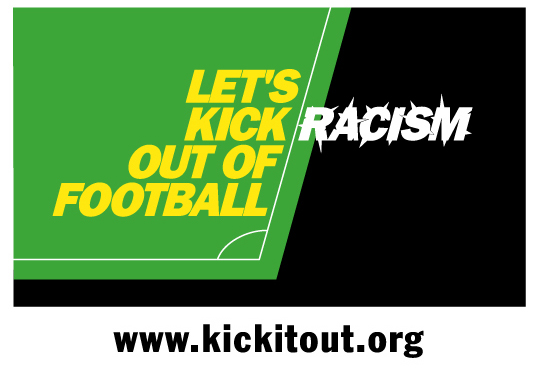

In [273]:
Image("KIO.jpg")